In [1]:
import zipfile
import os

files = zipfile.ZipFile('food101.zip', 'r')
files.extractall(os.getcwd())
files.close()  

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# imports
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import seaborn as sns

In [4]:
path = Path('food101')
path_meta = path /'meta'
path_images = path/'images'

In [5]:
path_meta

PosixPath('food101/meta')

In [6]:
def build_data_frame(path_name, file_name, img_format = 'jpg'):
    """
    build_data_frame input the path and file name, the function will return the dataframe with two columns:
    ['label'] : image label
    ['image_file'] : image file name with directory information
    input paramters:
    path_name : path 
    file_name : file name, string
    img_format : default format is jpg
    
    return dataframe
    """
    path_file = path_name/file_name
    file_df = pd.read_csv(path_file,delimiter='/', header=None, names=['label', 'image_file'])
    file_df['image_file'] = file_df['label'].astype(str) + '/' + file_df['image_file'].astype(str) + '.'+img_format
    
    return file_df

In [7]:
train_df = build_data_frame(path_meta, 'train.txt')
test_df = build_data_frame(path_meta, 'test.txt')

In [8]:
train_df.head()

,label,image_file
0,apple_pie,apple_pie/1005649.jpg
1,apple_pie,apple_pie/1014775.jpg
2,apple_pie,apple_pie/1026328.jpg
3,apple_pie,apple_pie/1028787.jpg
4,apple_pie,apple_pie/1043283.jpg


In [12]:
bs=64
bs_512 = int(bs/2)

train_model_data = (ImageList.from_df(df=train_df,path=path_images, cols=1)\
                            .split_by_rand_pct(0.2)\
                            .label_from_df(cols=0)\
                            .transform(size=512)\
                            .databunch(bs=bs_512)\
                            .normalize(imagenet_stats))
recompute_scale_factor=True

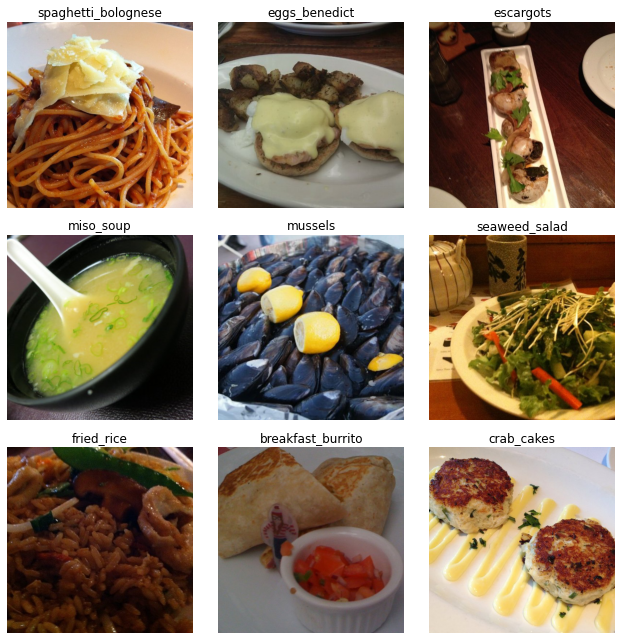

In [13]:
train_model_data.show_batch(rows=3, figsize=(9, 9))

In [14]:
top_5_accuracy = partial(top_k_accuracy, k=5)

learn = cnn_learner(train_model_data, models.resnet50, metrics=[accuracy, top_5_accuracy], callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:08<00:00, 12.1MB/s]


In [15]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=101, bias=True)
)

In [16]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 10.76 GiB total capacity; 9.69 GiB already allocated; 59.56 MiB free; 87.78 MiB cached)

In [ ]:
lr = 1e-2
learn.fit_one_cycle(8, slice(lr))
learn.save('food-101-ResNet50-512-nono')

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(8, max_lr=slice(1e-6, 1e-5))
learn.save('food-101-ResNet50-1e-6-5')